In [54]:
# Model
# Ridge regression, Random forest, Support vector regression, ARIMA, LSTM

In [1]:
# !pip install scikit-learn-intelex
from sklearnex import patch_sklearn 
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# time lag function
def time_lag_transform(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    
    cols, names = list(), list()
    
    # 입력값의 순서 (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]
    
    # 예측의 순서 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]
    
    # 합치기
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # NaN 값의 row를 제거
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg


In [3]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

# Ridge Regression
def Timeseries_RidgeR(data, train_idx, test_idx, lag=3):
    
    data = pd.DataFrame(data)
    reframed_df = time_lag_transform(data,n_in=lag).reset_index(drop=True)
    
    X_train = reframed_df.iloc[train_idx,0:len(data.columns)*lag].reset_index(drop=True)
    y_train = reframed_df.iloc[train_idx,lag].reset_index(drop=True)
    X_test = reframed_df.iloc[test_idx,0:len(data.columns)*lag].reset_index(drop=True)
    y_test = reframed_df.iloc[test_idx,lag].reset_index(drop=True)
    
    alphas = np.arange(0, 1, 0.03)
    ridgecv = RidgeCV(alphas = alphas, cv = 5) 
    ridgecv.fit(X_train, y_train)
    print("alpha : %.2f" % ridgecv.alpha_)
    
    ridge_train_pred = ridgecv.predict(X_train)
    ridge_test_pred = ridgecv.predict(X_test)
    
    return({'trainPrediction':ridge_train_pred, 'testPrediction':ridge_test_pred, 'y_test' :y_test.values})

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Random Forest Regression
def Timeseries_RFR(data, train_idx, test_idx, lag=3):
    data = pd.DataFrame(data)
    reframed_df = time_lag_transform(data,n_in=lag).reset_index(drop=True)
    
    X_train = reframed_df.iloc[train_idx,0:len(data.columns)*lag].reset_index(drop=True)
    y_train = reframed_df.iloc[train_idx,lag].reset_index(drop=True)
    X_test = reframed_df.iloc[test_idx,0:len(data.columns)*lag].reset_index(drop=True)
    y_test = reframed_df.iloc[test_idx,lag].reset_index(drop=True)

    params = {
        'n_estimators' : [100],
        'max_depth' : [6,8,10,12],
        'min_samples_leaf' : [8,12,8],
        'min_samples_split' : [8,16,20]
    }

    rf = RandomForestRegressor()
    grid_cv = GridSearchCV(rf, param_grid=params, cv=5)
    grid_cv.fit(X_train, y_train)
    print("최적 하이퍼 파라미터:\n", grid_cv.best_params_)
    
    rf_train_pred = grid_cv.predict(X_train)
    rf_test_pred = grid_cv.predict(X_test)
    
    return({'trainPrediction':rf_train_pred, 'testPrediction':rf_test_pred, 'y_test' :y_test.values})

In [5]:
# Support Vector Regression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

def Timeseries_SVR(data, train_idx, test_idx, lag=3):
    data = pd.DataFrame(data)
    reframed_df = time_lag_transform(data,n_in=lag).reset_index(drop=True)
    
    X_train = reframed_df.iloc[train_idx,0:len(data.columns)*lag].reset_index(drop=True)
    y_train = reframed_df.iloc[train_idx,lag].reset_index(drop=True)
    X_test = reframed_df.iloc[test_idx,0:len(data.columns)*lag].reset_index(drop=True)
    y_test = reframed_df.iloc[test_idx,lag].reset_index(drop=True)

    param_grid = [
        {'kernel':['linear'], 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
        {'kernel':['rbf'], 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
        {'gamma':[0.0001, 0.001, 0.01, 0.1, 1.0]}
    ]
    svr = SVR()
    grid_cv = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
    grid_cv.fit(X_train, y_train)
    print("최적 하이퍼 파라미터:\n", grid_cv.best_params_)
    
    svr_train_pred = grid_cv.predict(X_train)
    svr_test_pred = grid_cv.predict(X_test)
    
    return({'trainPrediction':svr_train_pred, 'testPrediction':svr_test_pred, 'y_test' :y_test.values})

In [6]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# ARIMA
def Timeseries_ARIMA(data, train_idx, test_idx, lag=14):
    
    data = pd.DataFrame(data)
    reframed_df = time_lag_transform(data,n_in=lag).reset_index(drop=True)
    X_train = reframed_df.iloc[train_idx,0:len(data.columns)*lag].reset_index(drop=True)
    y_train = reframed_df.iloc[train_idx,lag].reset_index(drop=True)
    y_test = reframed_df.iloc[test_idx,lag].reset_index(drop=True)
    
    auto_arima_model = auto_arima(y_train, 
                                  start_p=0, max_p=lag, 
                                  start_q=0, max_q=lag, 
                                  seasonal=False,
                                  d=1,
                                  trace=False,
                                  error_action='ignore',  
                                  suppress_warnings=True, 
                                  stepwise=False,
                       )
    auto_arima_model.fit(y_train)
    arima_pred = auto_arima_model.predict(n_periods=lag)
    print(auto_arima_model.summary())
    
    return({'arima_pred':arima_pred, 'y_test':y_test})

In [7]:
# LSTM

# 2차원 array를 1차원으로 변형, 후에 3차원으로 변형
def DimensionTransform(X):
    arr = []
    for m in range(X .shape[0]): # row 수만큼 반복하겠다
        for n in range(X.shape[1]): # column 수만큼 반복하겠다
            arr.append(X.tolist()[m][n])
    return(np.array(arr))
from sklearn.preprocessing import MinMaxScaler

# keras deep learning library
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

def Timeseries_LSTM(data, train_idx, test_idx, lag=3):
    
    data = pd.DataFrame(data)
    # scale data (딥러닝을 돌리기 위해서는 scale 필요)
    scaler = MinMaxScaler(feature_range=(0, 1)) # 0~1사이로 scale
    scaled = scaler.fit_transform(data.values)
    scaled_df = pd.DataFrame(scaled, columns=data.columns)
    
    reframed_df = time_lag_transform(scaled_df,n_in=lag).reset_index(drop=True)
    X_train = reframed_df.iloc[train_idx,0:len(data.columns)*lag].reset_index(drop=True)
    y_train = reframed_df.iloc[train_idx,len(data.columns)*lag].reset_index(drop=True)
    X_test = reframed_df.iloc[test_idx,0:len(data.columns)*lag].reset_index(drop=True)
    y_test = reframed_df.iloc[test_idx,len(data.columns)*lag].reset_index(drop=True)
    
    # 2차원 array를 1차원으로 변형, 후에 3차원으로 변형
    X_trainD = DimensionTransform(X_train.values)
    X_train = X_trainD.reshape(X_train.shape[0], lag, data.shape[1])
    
    # 2차원 array를 1차원으로 변형, 후에 3차원으로 변형
    X_testD = DimensionTransform(X_test.values)
    X_test = X_testD.reshape(X_test.shape[0], lag, data.shape[1])
    
    # LSTM의 구조
    model = Sequential()
    model.add(LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu')) # 하나의 층 8개의 노드, return_sequences=True 필수
    model.add(LSTM(4, activation='relu', return_sequences=False)) # 하나의층, 4개의 노드, 마지막에는 return_sequences=False
    model.add(Dense(1)) # 노드가 하나인 구조를 만들었다 (하나의 예측값으로 표현하기 위해)

    # model compile
    model.compile(loss='mse', optimizer='adam')

    # fit network
    history = model.fit(X_train, y_train, epochs=100, verbose=1, shuffle=False) # epochs : 반복횟수
    
    lstm_train_pred = model.predict(X_train)
    lstm_test_pred = model.predict(X_test)
    
    lstm_train_pred = lstm_train_pred.reshape(len(lstm_train_pred),)
    lstm_test_pred = lstm_test_pred.reshape(len(lstm_test_pred),)
    
    return({'trainPrediction':lstm_train_pred, 'testPrediction':lstm_test_pred, 'y_test' :y_test})

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./data/2010-2011 Solar home electricity data(perCustomer).csv')

df.head()

,date,Load(Customer1:CL),Load(Customer2:CL),Load(Customer3:CL),Load(Customer4:CL),Load(Customer5:CL),Load(Customer6:CL),Load(Customer7:CL),Load(Customer8:CL),Load(Customer9:CL),...,Load(Customer291:GG),Load(Customer292:GG),Load(Customer293:GG),Load(Customer294:GG),Load(Customer295:GG),Load(Customer296:GG),Load(Customer297:GG),Load(Customer298:GG),Load(Customer299:GG),Load(Customer300:GG)
0,2010-07-01 00:30:00,1.250,0.0,2.029,0.000,1.917,0.0,1.738,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-07-01 01:00:00,1.244,0.0,2.013,0.000,1.924,0.0,1.753,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-07-01 01:30:00,1.256,0.0,1.000,1.973,1.474,0.0,1.769,0.000,0.278,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-07-01 02:00:00,0.744,0.0,0.000,1.950,0.092,0.0,1.664,0.000,0.388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-07-01 02:30:00,0.019,0.0,0.000,1.544,1.020,0.0,0.000,0.944,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# 1row = 30 minute
# 2 row = 1 hour
# 48 row = 1 day
# 336 row = 1 weeks

In [10]:
# GC : General Consumption
GC = df.iloc[:,140:440]

# GG : Gross Generation
GG = df.iloc[:,440:]

# CL : Controlled Load consumption
CL = df.iloc[:,1:140]

In [11]:
GC.head()

,Load(Customer1:GC),Load(Customer2:GC),Load(Customer3:GC),Load(Customer4:GC),Load(Customer5:GC),Load(Customer6:GC),Load(Customer7:GC),Load(Customer8:GC),Load(Customer9:GC),Load(Customer10:GC),...,Load(Customer291:GC),Load(Customer292:GC),Load(Customer293:GC),Load(Customer294:GC),Load(Customer295:GC),Load(Customer296:GC),Load(Customer297:GC),Load(Customer298:GC),Load(Customer299:GC),Load(Customer300:GC)
0,0.303,0.085,0.669,0.075,0.0,0.044,0.093,0.124,0.033,0.031,...,0.398,0.044,0.006,0.102,0.059,0.019,0.205,0.096,1.464,0.279
1,0.471,0.142,0.671,0.086,0.0,0.041,0.100,0.088,0.019,0.051,...,0.413,0.056,0.000,0.203,0.062,0.048,0.106,0.110,1.413,0.924
2,0.083,0.082,0.675,0.085,0.0,0.047,0.090,0.150,0.008,0.052,...,0.276,0.588,0.009,0.236,0.037,0.030,0.169,0.080,1.428,0.803
3,0.121,0.119,0.683,0.084,0.0,0.046,0.051,0.097,0.009,0.043,...,0.307,0.069,0.000,0.160,0.081,0.019,0.270,0.105,1.445,0.066
4,0.361,0.105,0.694,0.084,0.0,0.047,0.148,0.115,0.009,0.026,...,0.264,0.031,0.008,0.176,0.041,0.018,0.255,0.089,1.407,0.089


In [12]:
GG.head()

,Load(Customer1:GG),Load(Customer2:GG),Load(Customer3:GG),Load(Customer4:GG),Load(Customer5:GG),Load(Customer6:GG),Load(Customer7:GG),Load(Customer8:GG),Load(Customer9:GG),Load(Customer10:GG),...,Load(Customer291:GG),Load(Customer292:GG),Load(Customer293:GG),Load(Customer294:GG),Load(Customer295:GG),Load(Customer296:GG),Load(Customer297:GG),Load(Customer298:GG),Load(Customer299:GG),Load(Customer300:GG)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
CL.head()

,Load(Customer1:CL),Load(Customer2:CL),Load(Customer3:CL),Load(Customer4:CL),Load(Customer5:CL),Load(Customer6:CL),Load(Customer7:CL),Load(Customer8:CL),Load(Customer9:CL),Load(Customer10:CL),...,Load(Customer284:CL),Load(Customer285:CL),Load(Customer286:CL),Load(Customer287:CL),Load(Customer289:CL),Load(Customer290:CL),Load(Customer293:CL),Load(Customer294:CL),Load(Customer297:CL),Load(Customer300:CL)
0,1.250,0.0,2.029,0.000,1.917,0.0,1.738,0.000,0.000,0.000,...,0.0,0.0,0.0,2.294,2.552,1.833,1.794,2.309,0.0,2.487
1,1.244,0.0,2.013,0.000,1.924,0.0,1.753,0.000,0.000,0.000,...,0.0,0.0,0.0,2.369,0.879,1.859,0.938,1.184,0.0,2.392
2,1.256,0.0,1.000,1.973,1.474,0.0,1.769,0.000,0.278,0.000,...,0.0,0.0,0.0,2.350,0.000,1.876,0.000,1.476,0.0,1.285
3,0.744,0.0,0.000,1.950,0.092,0.0,1.664,0.000,0.388,1.082,...,0.0,0.0,0.0,0.375,1.734,1.881,0.000,1.166,0.0,0.000
4,0.019,0.0,0.000,1.544,1.020,0.0,0.000,0.944,0.000,0.000,...,0.0,0.0,0.0,0.000,1.125,0.502,0.000,0.000,0.0,0.000


In [14]:
# Model
# Ridge regression, Random forest, Support vector regression, ARIMA, LSTM

# lag = 2 (1시간)
# lag = 48 (1일)
# lag = 336 (1주일)

In [15]:
data = CL.iloc[:,0]
train_idx = np.arange(336)
test_idx = np.arange(336,336+48)
lag = 48

In [16]:
# 일주일치 데이터로 하루 예측
ridge = Timeseries_RidgeR(data, train_idx, test_idx, lag=lag)

alpha : 0.99


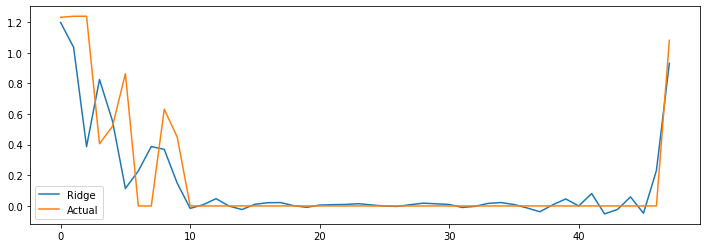

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(ridge['testPrediction'], label='Ridge')
plt.plot(ridge['y_test'], label='Actual')
plt.legend()
plt.show()

In [18]:
rf = Timeseries_RFR(data, train_idx, test_idx, lag=lag)

최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}


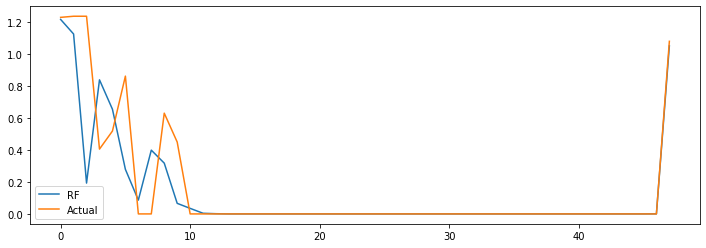

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(rf['testPrediction'], label='RF')
plt.plot(rf['y_test'], label='Actual')
plt.legend()
plt.show()

In [20]:
svr = Timeseries_SVR(data, train_idx, test_idx, lag=lag)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END .............................C=0.001, kernel=linear; total time=   0.0s
[CV] END .............................C=0.001, kernel=linear; total time=   0.0s
[CV] END .............................C=0.001, kernel=linear; total time=   0.0s
[CV] END .............................C=0.001, kernel=linear; total time=   0.0s
[CV] END .............................C=0.001, kernel=linear; total time=   0.0s
[CV] END ..............................C=0.01, kernel=linear; total time=   0.0s
[CV] END ..............................C=0.01, 

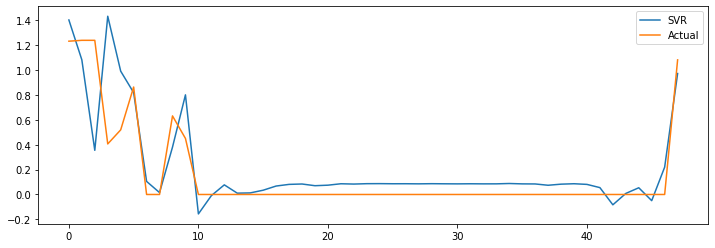

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(svr['testPrediction'], label='SVR')
plt.plot(svr['y_test'], label='Actual')
plt.legend()
plt.show()

In [22]:
arima = Timeseries_ARIMA(data, train_idx, test_idx, lag=48)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  336
Model:               SARIMAX(5, 1, 0)   Log Likelihood                 -42.064
Date:                Wed, 03 Aug 2022   AIC                             98.129
Time:                        03:55:24   BIC                            124.828
Sample:                             0   HQIC                           108.773
                                - 336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0024      0.016     -0.146      0.884      -0.035       0.030
ar.L1         -0.2828      0.031     -9.248      0.000      -0.343      -0.223
ar.L2         -0.1221      0.044     -2.748      0.0

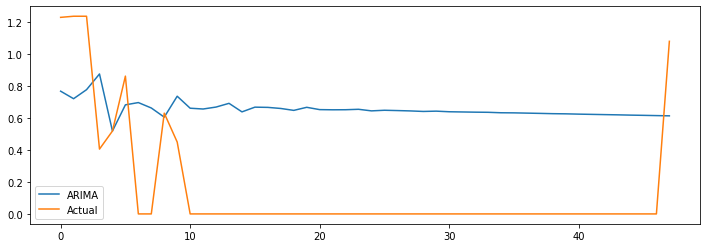

In [158]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(arima['arima_pred'], label='ARIMA')
plt.plot(arima['y_test'], label='Actual')
plt.legend()
plt.show()

In [52]:
lstm = Timeseries_LSTM(data, train_idx, test_idx, lag=lag)

Epoch 1/100
11/11 [==============================] - 3s 30ms/step - loss: 0.1005
Epoch 2/100
11/11 [==============================] - 0s 27ms/step - loss: 0.0937
Epoch 3/100
11/11 [==============================] - 0s 29ms/step - loss: 0.0882
Epoch 4/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0846
Epoch 5/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0823
Epoch 6/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0802
Epoch 7/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0780
Epoch 8/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0759
Epoch 9/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0729
Epoch 10/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0684
Epoch 11/100
11/11 [==============================] - 0s 27ms/step - loss: 0.0633
Epoch 12/100
11/11 [==============================] - 0s 29ms/step - loss: 0.0590
Epoch 13/100
11/11 [=====

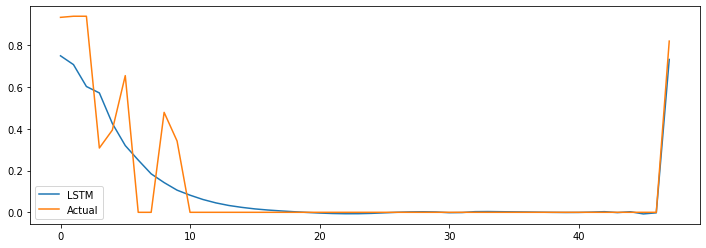

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(lstm['testPrediction'], label='LSTM')
plt.plot(lstm['y_test'], label='Actual')
plt.legend()
plt.show()

In [ ]:
ensemble = (svr['testPrediction']+rf['testPrediction']+ridge['testPrediction']+lstm['testPrediction'])/4

In [ ]:
ensemble = (svr['testPrediction']+rf['testPrediction']+ridge['testPrediction']+lstm['testPrediction'].reshape(len(lstm['testPrediction']),))/4

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(ridge['testPrediction'], label='Ridge')
plt.plot(rf['testPrediction'], label='Rf')
plt.plot(svr['testPrediction'], label='SVR')
plt.plot(lstm['testPrediction'], label='LSTM', color='blue', alpha=0.5)
plt.plot(lstm['y_test'], label='Actual', color='red')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(ensemble, label='Recrusive Bayesian Ensemble Model', color='blue')
plt.plot(lstm['y_test'], label='Actual', color='red')
plt.legend()
plt.show()